In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import glob
from pathlib import Path
from tqdm import tqdm
from skimage.restoration import denoise_tv_bregman
import sys
sys.path.append('utils/')
from nd_tools import scale_img
from rio_tools import get_cropped_profile, rasterize_shapes_to_array
from rasterio.transform import array_bounds
from shapely.geometry import box
import geopandas as gpd

# Data

In [2]:
data = (list(Path('data/jaxa_mosaics_cropped/').glob('*/*.tif')))
data = sorted(data, key=lambda x: x.name)
data

[PosixPath('data/jaxa_mosaics_cropped/hh/N05E100_07_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics_cropped/hv/N05E100_07_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped/hh/N05E100_08_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics_cropped/hv/N05E100_08_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped/hh/N05E100_09_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics_cropped/hv/N05E100_09_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped/hh/N05E100_10_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics_cropped/hv/N05E100_10_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped/hh/N05E100_15_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics_cropped/hv/N05E100_15_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped/hh/N05E100_16_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics_cropped/hv/N05E100_16_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped/hh/N05E100_17_sl_HH.tif'),
 PosixPath('data/jaxa_mosaics_cropped/hv/N05E100_17_sl_HV.tif'),
 PosixPath('data/jaxa_mosaics_cropped/hh/N05E100_18_sl_HH.tif'),
 PosixPath('data/jaxa_mos

In [3]:
with rasterio.open(data[0]) as ds:
    hh = ds.read(1)
    profile = ds.profile

with rasterio.open(data[1]) as ds:
    hv = ds.read(1)

In [4]:
hh.shape

(1000, 1000)

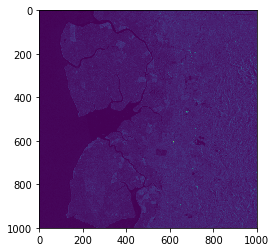

In [5]:
plt.imshow(hh)

In [6]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
    return band

def write_one_band(band, dest_path, profile):
    with rasterio.open(dest_path, 'w', **profile) as ds:
        ds.write(band, 1)

In [7]:
bands = list(map(open_one, data))

# To Decibels

In [8]:
# Want to remove things less than 0 because that will not transform with log well so we use floor operation
bands_clipped = list(map(lambda band: np.clip(band, .0000001, np.inf), tqdm(bands)))

100%|██████████| 16/16 [00:00<00:00, 239.22it/s]


In [9]:
# using the transformation from page 6 of
# https://www.eorc.jaxa.jp/ALOS/en/palsar_fnf/DatasetDescription_PALSAR2_Mosaic_FNF_revE.pdf
bands_db = list(map(lambda band: 20 * np.log10(band) -84.66 , tqdm(bands_clipped)))
bands_db = list(map(lambda band: np.clip(band, -40, 0), tqdm(bands_db)))

100%|██████████| 16/16 [00:00<00:00, 248.81it/s]


In [10]:
out_dir = Path('data/jaxa_mosaics_cropped_db')
out_dir.mkdir(exist_ok=True)

p = profile.copy()
p['dtype'] = 'float32'

hv_dir = out_dir/'hv'
hv_dir.mkdir(exist_ok=True, parents=True)

hh_dir = out_dir/'hh'
hh_dir.mkdir(exist_ok=True, parents=True)

for k, band in tqdm(enumerate(bands_db), total=len(bands_db)):
    dest_name = data[k].name.replace('_F02DAR', '')
    dest_dir = hh_dir if (k % 2) == 0 else hv_dir
    write_one_band(band.astype(np.float32), dest_dir/f'{dest_name}', p)

100%|██████████| 16/16 [00:00<00:00, 54.26it/s]


# TV and to Linear Scale

In [11]:
def bwd(img):
    return 10**(img / 20)

def tv_denoise(img_db, weight):
    img_tv = denoise_tv_bregman(img_db, weight)
    return img_tv

def tv_partial(band):
    return tv_denoise(band, .5)

In [12]:
bands_tv = list(map(tv_partial, tqdm(bands_db)))

100%|██████████| 16/16 [00:07<00:00,  1.87it/s]


In [13]:
out_dir = Path('data/jaxa_mosaics_cropped_tv')
out_dir.mkdir(exist_ok=True)

hv_dir = out_dir/'hv'
hv_dir.mkdir(exist_ok=True, parents=True)

hh_dir = out_dir/'hh'
hh_dir.mkdir(exist_ok=True, parents=True)

p = profile.copy()
p['dtype'] = 'float32'

for k, band in tqdm(enumerate(bands_tv), total=len(bands_tv)):
    dest_name = data[k].name.replace('_F02DAR', '')
    dest_dir = hh_dir if (k % 2) == 0 else hv_dir
    write_one_band(band.astype(np.float32), dest_dir/f'{dest_name}', p)

100%|██████████| 16/16 [00:00<00:00, 58.52it/s]


# RGB

In [14]:
out_dir = Path('data/rgb')
out_dir.mkdir(exist_ok=True)

band_tuples = [(bands_tv[2*k], bands_tv[2*k+1]) for k in range(8)]

def make_rgb(data_tuple):
    hh, hv = data_tuple
    m, n = hh.shape
    rgb = np.zeros((m, n, 3))
    
    hh_ = np.clip(hh, -35, -1)
    hv_ = np.clip(hv, -35, -1)

    rgb[..., 0] = scale_img(hh_)
    rgb[..., 1] = scale_img(hv_)
    rgb[..., 2] = np.clip(hh_ / (hv_), 0, 1)

    return rgb
    
rgbs = list(map(make_rgb, band_tuples))

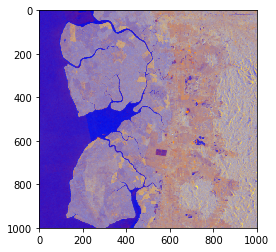

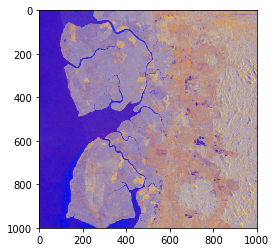

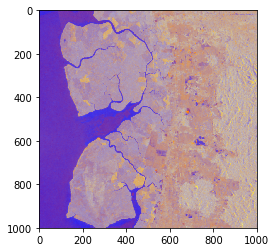

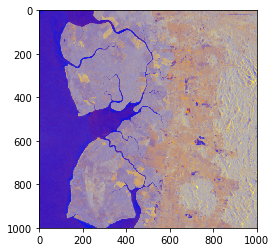

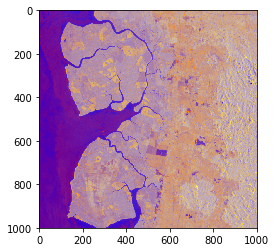

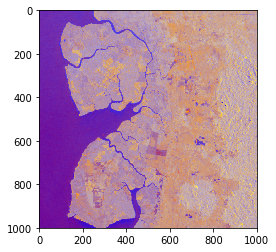

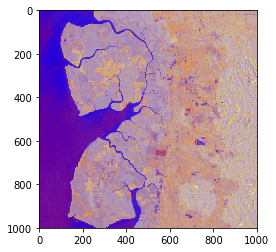

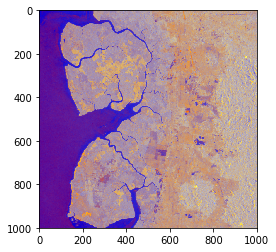

In [15]:
for k in range(8):
    plt.figure()
    plt.imshow(rgbs[k])

In [16]:
p_rgb = p.copy()
p_rgb['count'] = 3

for k, rgb in tqdm(enumerate(rgbs), total=len(rgbs)):
    dest_name = data[2 * k].name[:10]
    dest_name = f'{dest_name}_rgb.tif'
    
    dest_path = out_dir/dest_name
    with rasterio.open(dest_path, 'w', **p_rgb) as ds:
        ds.write(rgb.astype(np.float32).transpose(2, 0, 1))

100%|██████████| 8/8 [00:00<00:00, 22.21it/s]


# Getting Mangrove Mask

In [17]:
df_mangrove = gpd.read_file('data/GMW_2007_v2_cropped_extent/')

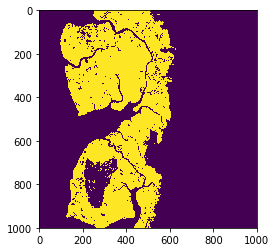

In [18]:
mangrove_mask = rasterize_shapes_to_array(df_mangrove.geometry, df_mangrove.pxlval, profile, all_touched=False)
plt.imshow(mangrove_mask)

In [19]:
p_mangrove = profile.copy()
p_mangrove['count'] = 1
p_mangrove['dtype'] = 'uint8'

with rasterio.open('data/mangrove_extent.tif',  'w', **p_mangrove) as ds:
    ds.write(mangrove_mask.astype(np.uint8), 1)